# 230518_causal_tracing_weights_v1

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir

/rds/general/user/jj1122/home/anaconda3/envs/test1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
# dataset_nm = "Health_and_fitness"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"

In [3]:
data_dir = "../m2d2/dataset"

In [4]:
def get_model_path(model_id):
    model_path_format = "/rds/general/user/jj1122/home/projects/m2d2/dataset/{model_id}/models"
    ckpt_path_format = "/checkpoint-{ckpt}"

    if model_id == "gpt2":
        model_path = "gpt2"
#         ckpt = "zs"
    else:
        model_path = model_path_format.format(model_id=model_id)
        l_dir = listdir(model_path)

        if all([len(x.split(".")) == 1 for x in l_dir]):
            ckpt = max([int(x.split("-")[1]) for x in l_dir])
            model_path += ckpt_path_format.format(ckpt=ckpt)
#         else:
#             ckpt = "final"
    return model_path

    

In [5]:
get_model_path("cs_l1")

'/rds/general/user/jj1122/home/projects/m2d2/dataset/cs_l1/models'

In [6]:
list_models = [
    "cs_l1",
    "nlin_l1",
    "Health_and_fitness",
    "Natural_and_physical_sciences",
    "Religion_and_belief_systems",
    "Culture_and_the_arts",
    "General_referece",
    "econ_l1",
    "History_and_events",
    "Mathematics_and_logic",
    "q-fin_l1",
    "Philosophy_and_thinking",
    "Society_and_social_sciences"
]

In [7]:
config_models = {model_id: {} for model_id in list_models}
for model_id in list_models:
    config_models[model_id]["model_path"] = get_model_path(model_id)

In [8]:
config_models

{'cs_l1': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/cs_l1/models'},
 'nlin_l1': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/nlin_l1/models'},
 'Health_and_fitness': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/Health_and_fitness/models'},
 'Natural_and_physical_sciences': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/Natural_and_physical_sciences/models'},
 'Religion_and_belief_systems': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/Religion_and_belief_systems/models'},
 'Culture_and_the_arts': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/Culture_and_the_arts/models'},
 'General_referece': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/General_referece/models'},
 'econ_l1': {'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/econ_l1/models'},
 'History_and_events': {'model_path': '/rds/general/user/jj1122/home/p

In [9]:
device_id = 'cpu'

# tuned_model_paths = "../m2d2/dataset/Health_and_fitness/models/checkpoint-20000/"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [10]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load models

In [29]:
dict_models = {}
for k, v_dict in config_models.items():
    print(k)
    dict_models[k] = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    


Religion_and_belief_systems
General_referece
nlin_l1
Health_and_fitness
cs_l1


In [30]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

## Get difference of weights
```diff = np.mean(np.abs(model_a.weights - model_b.weights))```

In [31]:
dict_diff_weights = {}
for k, tuned_model in dict_models.items():
    for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
        dict_diff_weights[k +"."+tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    


In [32]:
df_avg_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index')

In [33]:
df_avg_diff_weights = df_avg_diff_weights.reset_index()
df_avg_diff_weights.columns = ["code", "diff"]

In [35]:
df_avg_diff_weights["code_split"] = df_avg_diff_weights["code"].str.split(".")
df_avg_diff_weights["dataset"] = df_avg_diff_weights["code_split"].apply(lambda l: l[0])
# df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"][2]
df_avg_diff_weights["layer"] = df_avg_diff_weights["code_split"].apply(lambda l: int(l[3]) if l[2] == "h" else -1)
df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"].apply(lambda l: l[4] if l[2] == "h" else l[2])
df_avg_diff_weights["w_or_b"] = df_avg_diff_weights["code_split"].apply(lambda l: l[-1])

del df_avg_diff_weights["code"], df_avg_diff_weights["code_split"]

In [37]:
df_avg_diff_weights.loc[df_avg_diff_weights.layer != -1]

,diff,dataset,layer,module,w_or_b
2,0.024056,Religion_and_belief_systems,0,ln_1,weight
3,0.006673,Religion_and_belief_systems,0,ln_1,bias
4,0.015205,Religion_and_belief_systems,0,attn,weight
5,0.011436,Religion_and_belief_systems,0,attn,bias
6,0.010350,Religion_and_belief_systems,0,attn,weight
...,...,...,...,...,...
733,0.014882,cs_l1,11,ln_2,bias
734,0.030184,cs_l1,11,mlp,weight
735,0.008063,cs_l1,11,mlp,bias
736,0.036656,cs_l1,11,mlp,weight


# Result

### Avg diff group by layer number

In [54]:
df_avg_diff_weights.loc[df_avg_diff_weights.layer != -1]\
    .groupby(["w_or_b", "layer"])[['diff']].describe()[[('diff', 'mean'), ('diff', 'std')]]\
    .sort_values(by=[('diff', 'mean'), ('diff', 'std')]).unstack(-2)

diff                              
            mean                 std          
w_or_b      bias    weight      bias    weight
layer                                         
0       0.005424  0.018411  0.003830  0.008636
1       0.004104  0.010829  0.002321  0.005719
2       0.004952  0.012249  0.003189  0.006069
3       0.003729  0.012651  0.001992  0.006267
4       0.003214  0.012810  0.001420  0.006213
5       0.004334  0.013397  0.003130  0.005885
6       0.003143  0.013661  0.001289  0.006093
7       0.003332  0.014153  0.001347  0.007005
8       0.003729  0.014572  0.001685  0.007522
9       0.004311  0.015131  0.002068  0.007870
10      0.005497  0.016623  0.002333  0.008210
11      0.007107  0.023247  0.002854  0.015040

<Axes: xlabel='layer', ylabel='diff'>

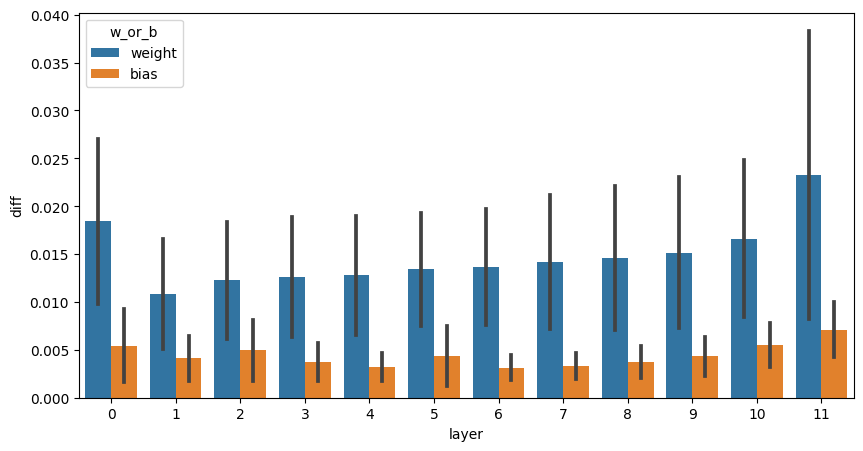

In [45]:
plt.rcParams["figure.figsize"] = (10,5)

sns.barplot(df_avg_diff_weights.loc[df_avg_diff_weights.layer != -1], x='layer', y='diff', errorbar='sd', hue="w_or_b")

- weight: The first and last layers changed the most
- bias: no insightful pattern

### Avg diff group by module

In [55]:
df_avg_diff_weights.loc[df_avg_diff_weights.layer != -1]\
    .groupby(["w_or_b", "module"])[['diff']].describe()[[('diff', 'mean'), ('diff', 'std')]]\
    .sort_values(by=[('diff', 'mean'), ('diff', 'std')]).unstack(-2)

diff                              
            mean                 std          
w_or_b      bias    weight      bias    weight
module                                        
attn    0.004261  0.016026  0.002106  0.005917
ln_1    0.006750  0.013198  0.002351  0.008798
ln_2    0.005334  0.010799  0.003101  0.013099
mlp     0.002917  0.016408  0.001867  0.006549

<Axes: xlabel='module', ylabel='diff'>

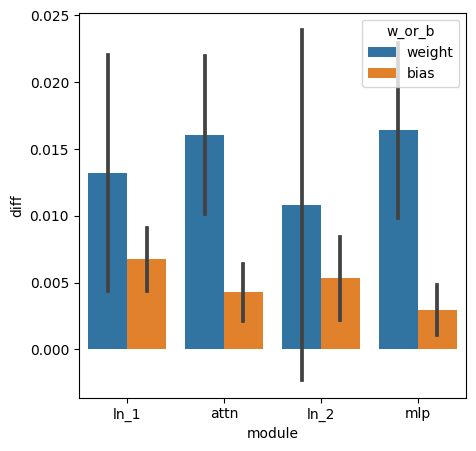

In [59]:
plt.rcParams["figure.figsize"] = (5,5)

sns.barplot(df_avg_diff_weights.loc[df_avg_diff_weights.layer != -1], x='module', y='diff', errorbar='sd', hue="w_or_b")

### Avg diff "weight" group by layer and module

<Axes: xlabel='layer', ylabel='diff'>

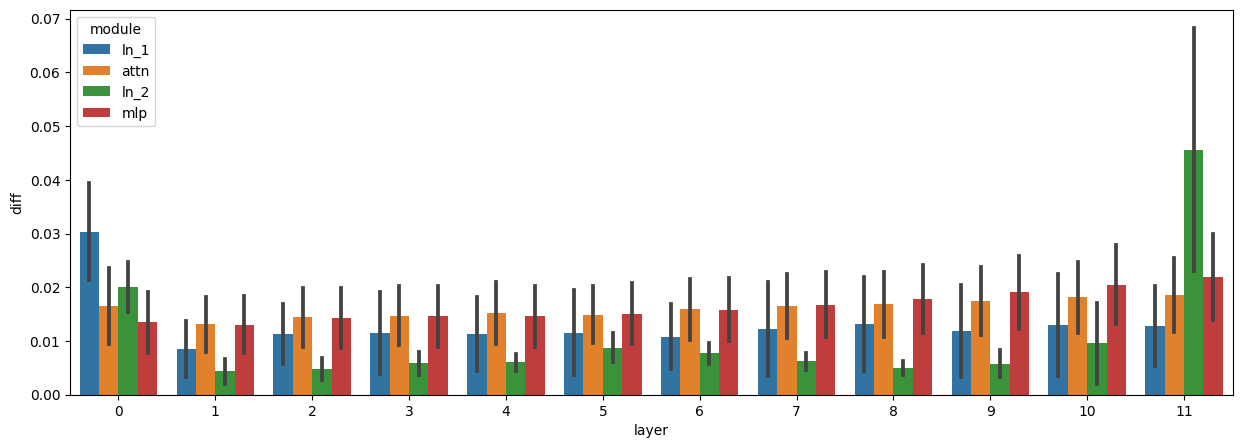

In [56]:
plt.rcParams["figure.figsize"] = (15,5)

sns.barplot(df_avg_diff_weights.loc[(df_avg_diff_weights.layer != -1) & (df_avg_diff_weights.w_or_b == 'weight')], x='layer', hue='module', y='diff', errorbar='sd')

- key, Query, Value
- how many parameters
- which parameters are changed the most by rank

- The first ln_1 and the last ln_2 changed the most
- mlp and attn weight show equally changed 

### Avg diff "bias" group by layer and module

<Axes: xlabel='layer', ylabel='diff'>

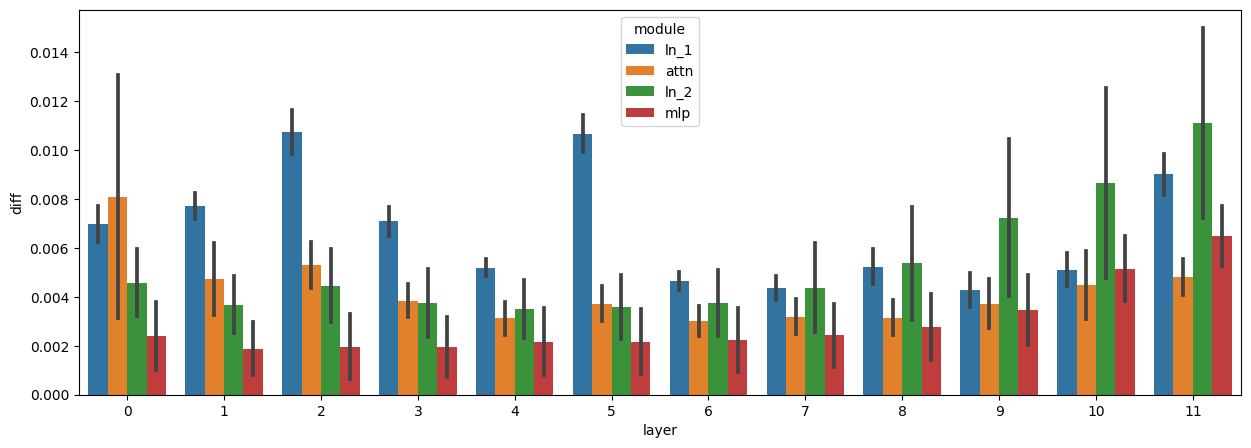

In [57]:
plt.rcParams["figure.figsize"] = (15,5)

sns.barplot(df_avg_diff_weights.loc[(df_avg_diff_weights.layer != -1) & (df_avg_diff_weights.w_or_b == 'bias')], x='layer', hue='module', y='diff', errorbar='sd')